In [10]:
import uproot
import numpy as np
import os
import sys
sys.path.append("/home/nlebas/grand/Grand_analysis")
from PWF_reconstruction.recons_PWF import PWF_semianalytical, cov_matrix
from PWF_reconstruction.utils import sph2cart, create_times
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from grand import ECEF, Geodetic, GRANDCS, LTP
import pandas as pd

In [11]:
# !which python

In [12]:
# !source ~/Documents/WorkingDir/grand/env/setup.sh

In [ ]:
with uproot.open("/home/nlebas/Documents/LPNHE/GRAND/Local_Data/data_files/GP80_20250309_235256_RUN10070_CD_20dB_23DUs_GP43-ChY-X2X-Y2Y-CD-10000-22.root") as f:
    du_ids = f['tadc']['du_id'].array()
    du_s = f['tadc']['du_seconds'].array()
    du_ns = f['tadc']['du_nanoseconds'].array()
    du_t = []
    for s, ns in zip(du_s, du_ns):
        t = (s-1741535668 + ns * 1e-9).to_numpy()   # pas mal de retrancher 1741535668 pour ne pas avoir de trop grosse valeurs
        # t -= t.mean()
        du_t.append(t)
    du_long = f['trawvoltage']['gps_long'].array()
    du_lat = f['trawvoltage']['gps_lat'].array()
    du_alt = f['trawvoltage']['gps_alt'].array()
    print(du_t)

[array([ 0.00000000e+00,  1.43051147e-06, -1.90734863e-06]), array([0.]), array([0.]), array([ 3.33786011e-06, -3.33786011e-06]), array([ 0.00000000e+00, -4.76837158e-07]), array([ 3.81469727e-06, -6.19888306e-06,  9.53674316e-07,  9.53674316e-07]), array([ 6.67572021e-06,  3.81469727e-06,  0.00000000e+00, -6.67572021e-06,
       -4.76837158e-06]), array([-1.90734863e-06,  4.76837158e-06,  1.43051147e-06, -3.81469727e-06]), array([-1.90734863e-06,  1.43051147e-06,  4.76837158e-06, -1.90734863e-06,
       -3.33786011e-06]), array([ 5.72204590e-06,  9.53674316e-07, -9.53674316e-07, -4.29153442e-06]), array([-1.90734863e-06,  0.00000000e+00,  3.33786011e-06,  0.00000000e+00]), array([ 4.29153442e-06,  9.53674316e-07,  9.53674316e-07, -5.72204590e-06]), array([ 5.72204590e-06, -6.19888306e-06,  2.38418579e-06,  2.38418579e-06,
       -5.72204590e-06]), array([-4.76837158e-07,  6.19888306e-06, -5.24520874e-06, -4.76837158e-07]), array([ 1.43051147e-06,  1.43051147e-06,  0.00000000e+00, -2.3

In [ ]:
# Define the center station (example coordinates). /!\ Change this to the actual DAQ coordinate to correspond to the data !
daq = Geodetic(latitude=40.99746387, longitude=93.94868871, height=1215)
all_pos = dict()
for ev_idx in range(len(du_ids)):
    for i in range(len(du_ids[ev_idx])):
        dus_feb = Geodetic(
            latitude=du_lat[ev_idx].to_numpy()[i],
            longitude=du_long[ev_idx].to_numpy()[i],
            height=du_alt[ev_idx].to_numpy()[i],
            )
        dus_feb = GRANDCS(dus_feb, obstime="2024-09-15", location=daq)
        all_pos[du_ids[ev_idx][i]] = [dus_feb.x[0], dus_feb.y[0], dus_feb.z[0]]
        
pos_df = pd.DataFrame.from_dict(all_pos, orient='index', columns=['x', 'y', 'z'])
du_pos = []
for ids in du_ids:
    du_pos.append(pos_df.loc[ids.to_numpy()].to_numpy())

[array([[-5195.1592769 , -2923.69797654,    26.11992252],
       [-5694.43592894, -2636.97408058,    36.326279  ],
       [-4697.95019695, -3213.67162789,    10.94854023]]), array([[-4195.18060114, -2927.40599427,    14.78594378]]), array([[-6194.42860557, -2345.02837171,    44.59695575]]), array([[-4696.42880894,  -903.92209105,    19.40030707],
       [-4195.18060114, -2927.40599427,    14.78594378]]), array([[-4696.47002385,  -328.54722593,    34.62906037],
       [-5196.35015114,  -615.33054133,    32.07873806]]), array([[-6194.55734054,   -39.33354956,    57.1494511 ],
       [-5195.1592769 , -2923.69797654,    26.11992252],
       [-6192.00438336, -1190.7879596 ,    35.2071594 ],
       [-5695.2825584 ,  -902.08812102,    41.35521634]]), array([[-6.19455734e+03, -3.93335496e+01,  5.71494511e+01],
       [-4.69647002e+03, -3.28547226e+02,  3.46290604e+01],
       [-6.19442861e+03, -2.34502837e+03,  4.45969557e+01],
       [-4.19594613e+03, -3.50355657e+03,  3.46226838e+00],
      

In [ ]:
theta_rec = []
phi_rec = []
Chi2 = []
for pos, t in zip(du_pos, du_t):
    if len(pos) <= 4:
        continue
    theta, phi = PWF_semianalytical(pos, t)
    
    
    k = -sph2cart(theta, phi)
    t_recons = create_times(pos, k, sigma=0)
    assert  t_recons.shape == t.shape
    chi2 = chi2_PWF_n(t - t.mean(), t_recons-t_recons.mean(), sigma=5e-9)

    theta_rec.append(theta)
    phi_rec.append(phi)
    Chi2.append(chi2)

theta_rec = np.array(theta_rec)
phi_rec = np.array(phi_rec)
Chi2 = np.array(Chi2)
Chi2*1e18

array([], dtype=float64)

# Après ce n'est plus que pour les plots

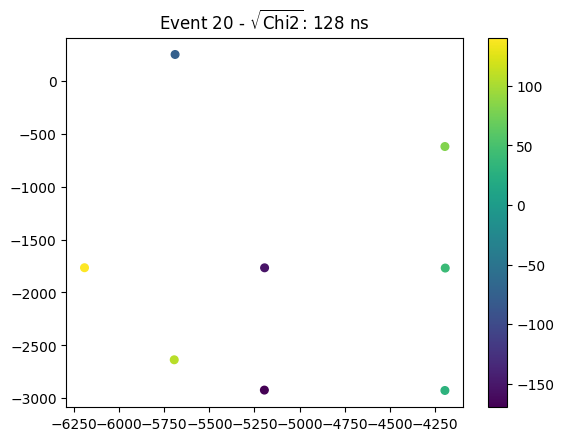

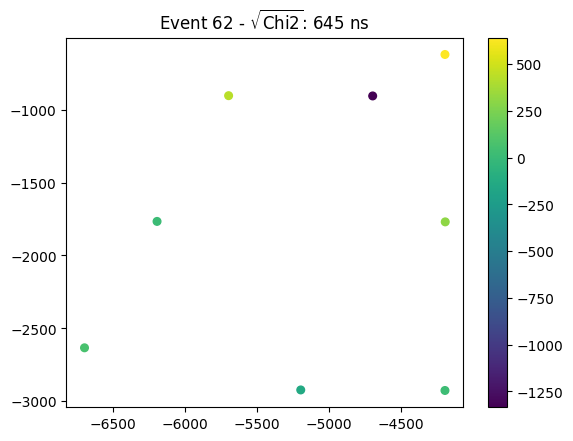

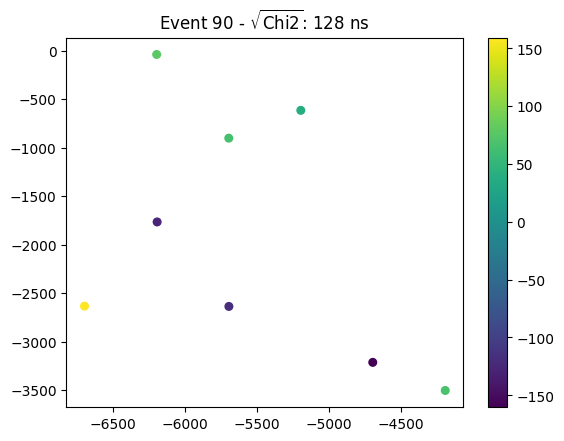

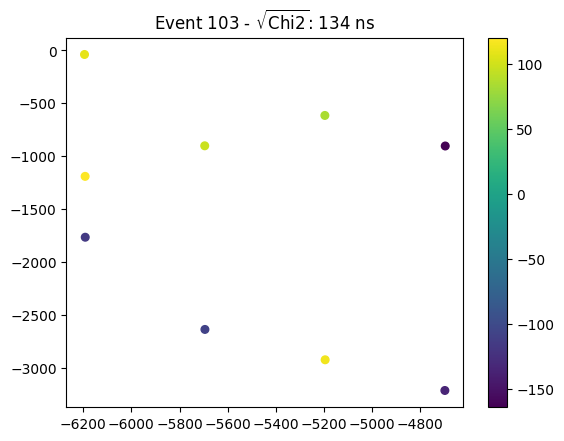

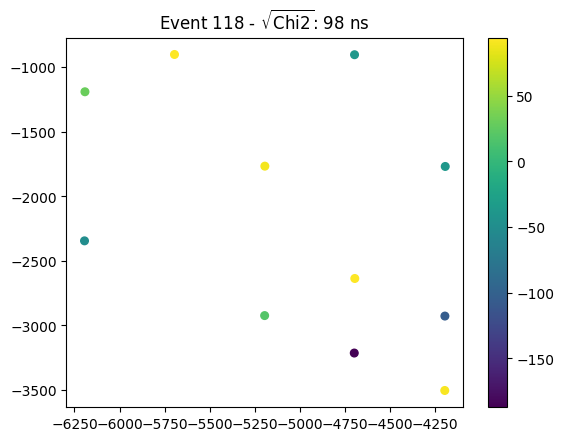

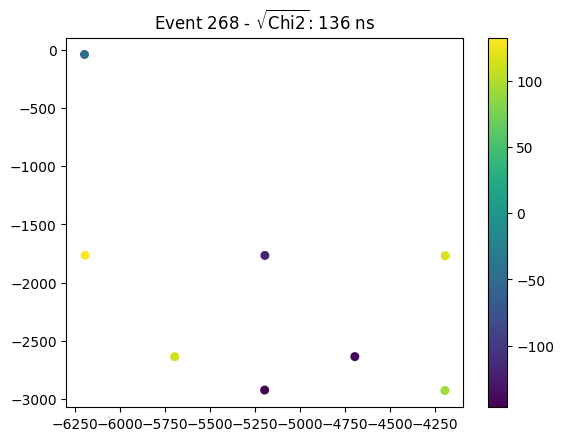

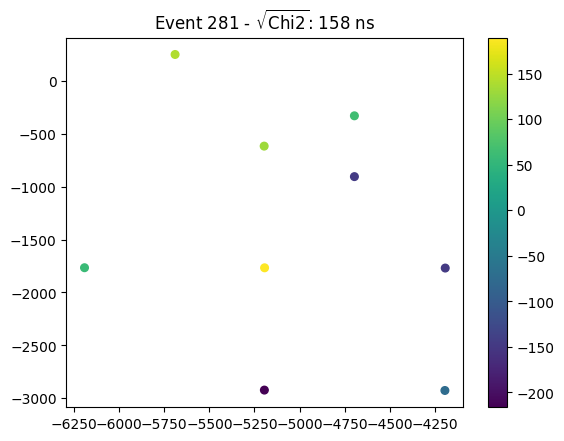

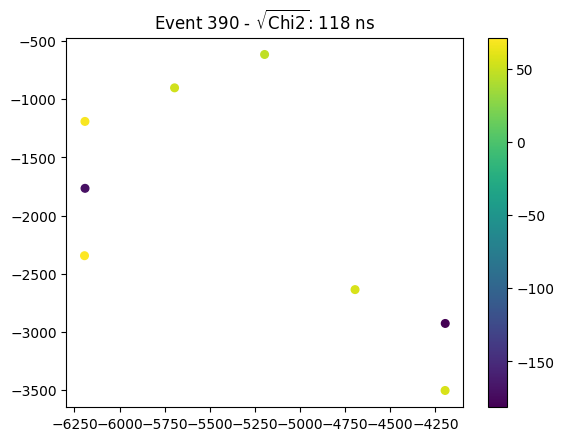

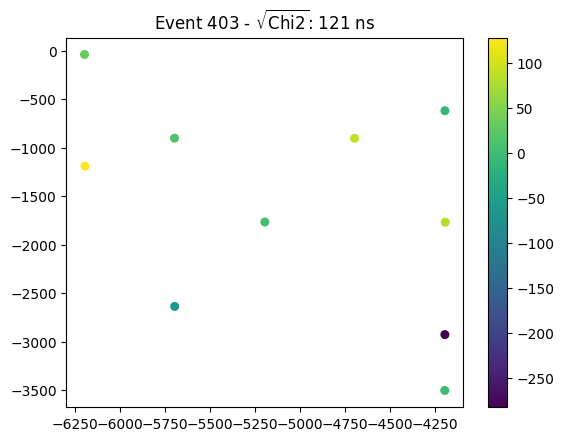

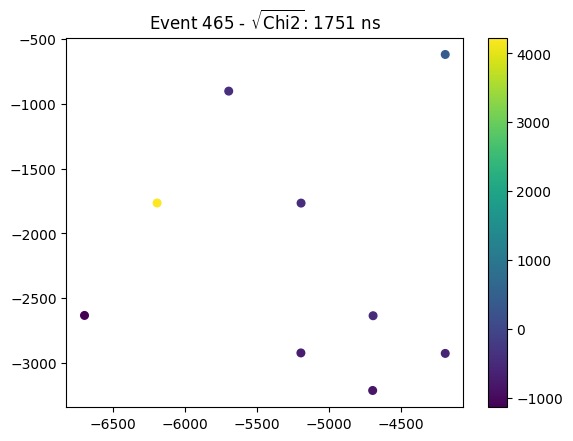

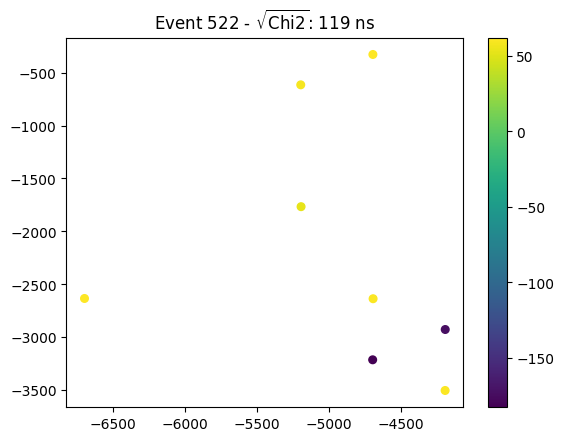

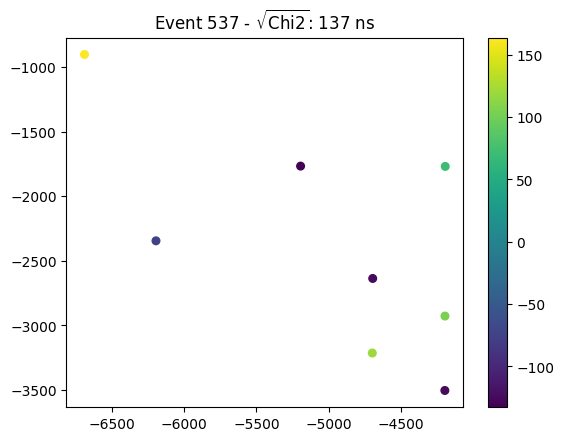

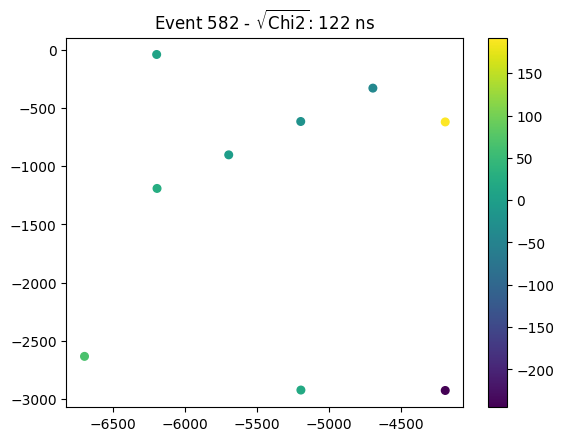

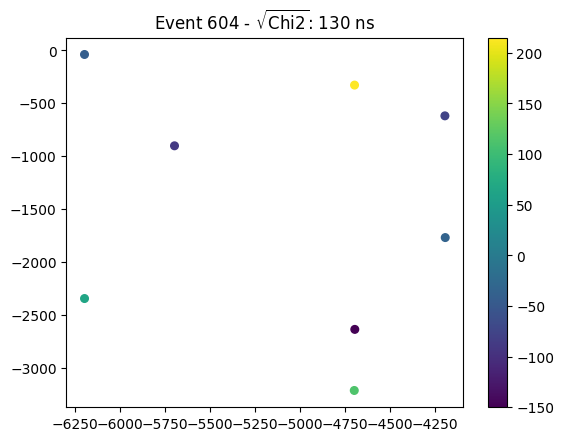

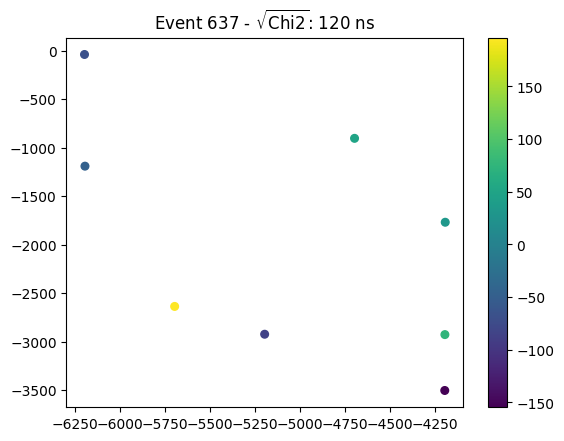

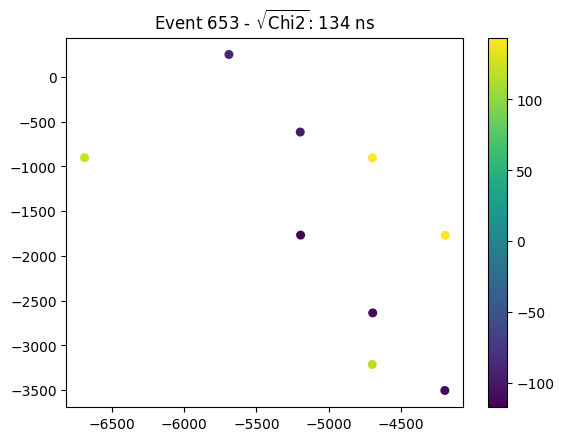

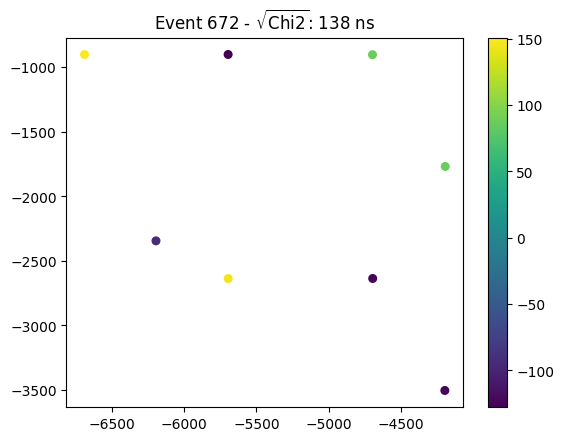

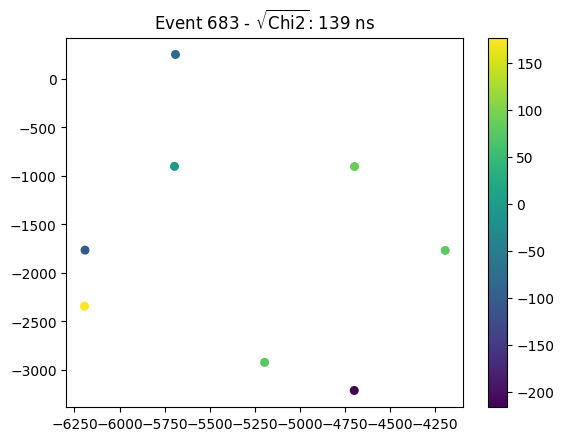

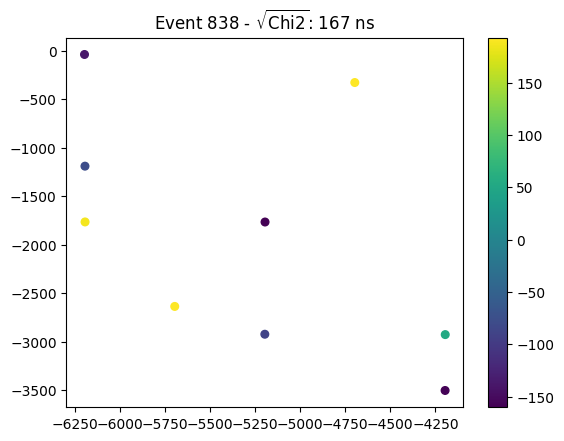

In [66]:
for ev_index in range(850):
    if len(du_pos[ev_index]) <= 7:
        continue
    t = du_t[ev_index]
    theta, phi = PWF_semianalytical(du_pos[ev_index], t)
    t_recons = create_times(du_pos[ev_index], -sph2cart(theta, phi), sigma=0)
    fig, ax = plt.subplots(1,1)
    ax.scatter(du_pos[ev_index][:,0], du_pos[ev_index][:,1], c=(t-t.mean() - t_recons)*1e9, s=30)

    chi2 = chi2_PWF_n(t - t.mean(), t_recons-t_recons.mean())*1e18
    ax.set_title(f'Event {ev_index} - $\sqrt{{ \\rm{{Chi2}} }}$: {np.sqrt(chi2):.0f} ns')
    plt.colorbar(ax.collections[0])
    plt.show()

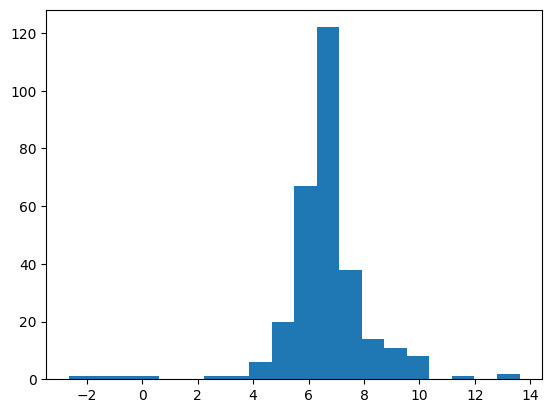

In [37]:
plt.hist(np.log(Chi2), bins=20);

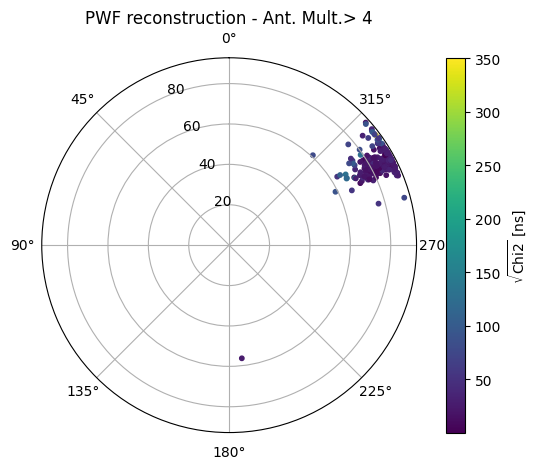

In [70]:
fig, ax = plt.subplots(1,1, subplot_kw={'projection': 'polar'})
scat = ax.scatter(phi_rec[np.sqrt(Chi2)<600], theta_rec[np.sqrt(Chi2)<600]*180/np.pi, c=np.sqrt(Chi2)[np.sqrt(Chi2)<600], s=10)
cb = plt.colorbar(scat)
cb.set_label('$\sqrt{{ \\rm{{Chi2}} }}$ [ns]')
ax.set_theta_zero_location("N")
ax.set_title('PWF reconstruction - Ant. Mult.> 4')
plt.tight_layout()

In [7]:
np.sqrt(10000/25)

20.0

array([1082, 1081, 1013], dtype=uint32)

In [35]:
print([len(ids) for ids in du_ids])

[3, 1, 1, 2, 2, 4, 5, 4, 5, 4, 4, 4, 5, 4, 4, 4, 4, 4, 3, 3, 8, 4, 6, 5, 5, 5, 4, 5, 4, 7, 4, 6, 4, 4, 3, 3, 5, 4, 3, 5, 4, 6, 6, 4, 3, 4, 3, 3, 5, 5, 3, 4, 4, 5, 4, 5, 4, 4, 4, 5, 5, 3, 8, 5, 4, 5, 4, 4, 4, 5, 4, 5, 4, 5, 7, 3, 4, 4, 5, 4, 3, 3, 6, 4, 4, 7, 5, 4, 4, 4, 8, 3, 5, 4, 7, 6, 4, 4, 4, 4, 4, 4, 3, 9, 5, 4, 6, 4, 3, 4, 6, 6, 4, 3, 4, 4, 3, 5, 11, 2, 4, 6, 4, 2, 4, 5, 6, 4, 4, 6, 2, 3, 4, 6, 3, 4, 4, 5, 3, 4, 3, 2, 3, 3, 4, 5, 2, 6, 4, 3, 5, 6, 3, 5, 6, 4, 4, 4, 4, 4, 4, 3, 3, 5, 5, 4, 4, 4, 5, 7, 3, 5, 4, 3, 3, 4, 3, 4, 5, 3, 3, 4, 2, 3, 4, 5, 4, 5, 7, 4, 3, 5, 6, 4, 4, 3, 4, 4, 4, 3, 4, 4, 4, 3, 4, 4, 4, 4, 5, 4, 4, 5, 4, 4, 4, 4, 5, 5, 3, 4, 4, 5, 3, 6, 3, 5, 4, 4, 5, 4, 4, 6, 6, 4, 7, 5, 4, 4, 5, 4, 7, 4, 3, 4, 4, 4, 6, 4, 4, 3, 4, 5, 7, 3, 5, 4, 3, 3, 4, 7, 3, 4, 4, 4, 6, 4, 4, 4, 8, 4, 6, 4, 5, 4, 4, 3, 4, 4, 5, 5, 4, 9, 7, 5, 3, 3, 3, 4, 4, 6, 4, 4, 5, 3, 4, 4, 5, 4, 5, 4, 4, 6, 5, 3, 6, 4, 4, 5, 4, 3, 4, 3, 7, 4, 4, 3, 3, 4, 4, 7, 7, 4, 4, 4, 5, 4, 4, 5, 6, 3, 5, 3, 3,

In [6]:
coord_DAQ = Geodetic(latitude=40.99434, longitude=93.94177, height=1262.376)

full_list_coord = np.loadtxt('/sps/grand/jlavoisier/output/GP13_T3_offline/list_antennas_GP65_CD.txt')

with open(f"/sps/grand/jlavoisier/output/GP13_T3_offline/list_antennas_GP80_xyz_origin_DAQ.txt", 'w') as f_xyz :
    for i in range(np.shape(full_list_coord)[0]) :
        coord_ant = Geodetic(latitude=full_list_coord[i,0], longitude=full_list_coord[i,1], height=full_list_coord[i,2])
        coord_xy_ant = GRANDCS(coord_ant, obstime="1970-01-01", location=coord_DAQ)
        f_xyz.write(f"{full_list_coord[i,0]} {coord_xy_ant[0]} {coord_xy_ant[1]} {coord_xy_ant[2]}")

Welcome to JupyROOT 6.26/10


FileNotFoundError: /sps/grand/jlavoisier/output/GP13_T3_offline/list_antennas_GP65_CD.txt not found.

In [ ]:
def plot_geolocation(self):
    """
    Plot the geolocation of the detection units using their GPS data.
    """
    unique_du, idx = np.unique(self.data._du_ids, return_index=True)
    
    
    # Define the center station (example coordinates). /!\ Change this to the actual DAQ coordinate to correspond to the data !
    daq = Geodetic(latitude=40.99746387, longitude=93.94868871, height=1215)
    dus_feb = Geodetic(
        latitude=self.data._du_lat[idx],
        longitude=self.data._du_long[idx],
        height=self.data._du_alt[idx]
    )
    dus_feb = GRANDCS(dus_feb, obstime="2024-09-15", location=daq)
    
    plt.figure()
    plt.plot(-dus_feb.y, dus_feb.x, 'ob', label="Detector Units")
    plt.plot(0, 0, 'or', label="Center Station")
    for i, du in enumerate(unique_du):
        plt.text(-dus_feb.y[i] + 50, dus_feb.x[i], str(du), fontsize=12)
    plt.xlabel("Easting (m)")
    plt.ylabel("Northing (m)")
    plt.title("Geolocation of Detection Units")
    plt.legend()
    plt.show()